In [4]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

## AE

In [5]:
dataset = datasets.MNIST('.', download=True)

In [6]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

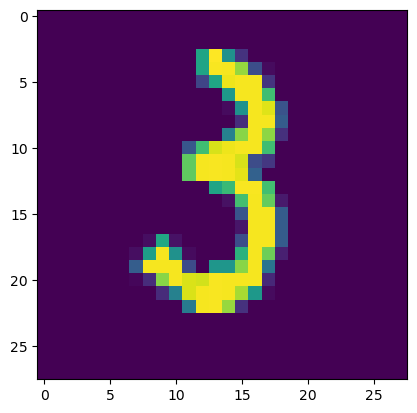

In [7]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[1234].detach().numpy())
plt.show()

In [42]:
# hyperparams
in_chan = 1
hidden_ch = 64
out_ch = 3
device_id = 0
device = 'cpu' if device_id == -1 else 'mps'
n_epochs = 4
batch_size = 128

In [43]:
class Encoder(nn.Module):
  #28x28 -> 14x14 -> 7x7 
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.MaxPool2d(2, 2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7 x 7
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.do3 = nn.Dropout(0.1)
    self.conv4 = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.pool1(self.conv1(x))))
    x = self.do2(self.activ(self.pool2(self.conv2(x))))
    x = self.do3(self.activ(self.conv3(x)))
    x = self.conv4(x)

    return x

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample1 = nn.UpsamplingBilinear2d(scale_factor=2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=5, stride=1, padding=2)
    self.activ = nn.ReLU()
    

  def forward(self, x):
    x = self.do1(self.activ(self.upsample1(self.conv1(x))))
    x = self.do2(self.activ(self.upsample2(self.conv2(x))))
    x = self.conv3(x)    

    return x

class ConvAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = Encoder(in_chan, hidden_ch, out_ch)
    self.decoder = Decoder(in_chan, hidden_ch, out_ch)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [44]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [45]:
model_conv = ConvAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.MSELoss()

epoch: 0, step: 0, loss: 0.10543400049209595
epoch: 0, step: 200, loss: 0.01242363452911377
epoch: 0, step: 400, loss: 0.010140636004507542


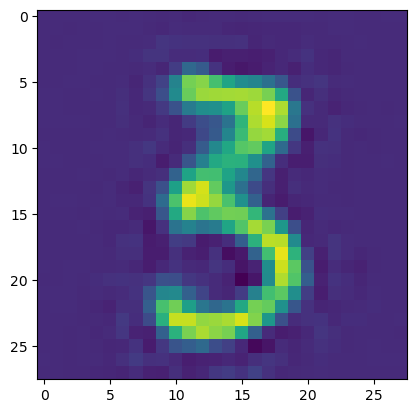

epoch: 1, step: 0, loss: 0.009582455269992352
epoch: 1, step: 200, loss: 0.008447939530014992
epoch: 1, step: 400, loss: 0.008008014410734177


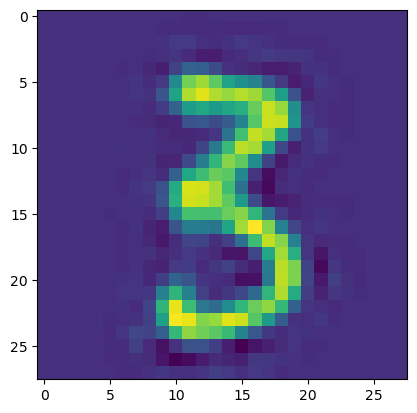

epoch: 2, step: 0, loss: 0.00776473805308342
epoch: 2, step: 200, loss: 0.007416240870952606
epoch: 2, step: 400, loss: 0.0073768459260463715


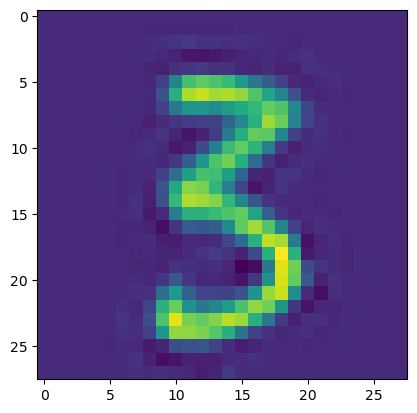

epoch: 3, step: 0, loss: 0.007452377118170261
epoch: 3, step: 200, loss: 0.00726840365678072
epoch: 3, step: 400, loss: 0.006653818301856518


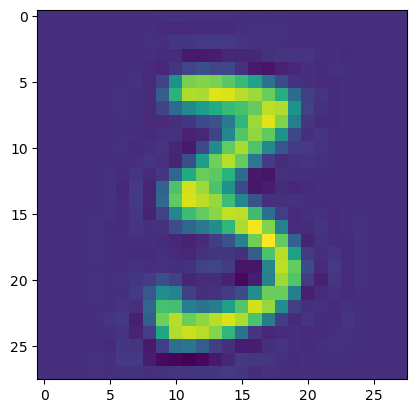

In [46]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['data'].to(device))
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1144].unsqueeze(0).unsqueeze(0).float()/255
  plt.imshow(model_conv(item.to(device)).squeeze().cpu().detach().numpy())
  plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')

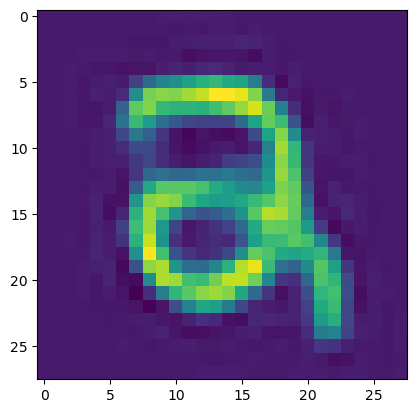

In [114]:
item = dataset.data[1134].unsqueeze(0).unsqueeze(0).float()/255
plt.imshow(model_conv(item.to(device)).squeeze().cpu().detach().numpy())
plt.show()

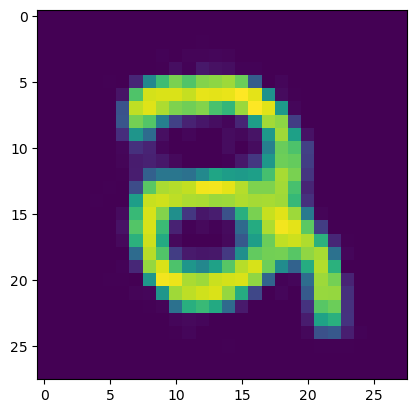

In [149]:
some_fint = nn.Tanh()
plt.imshow((some_fint(model_conv(item.to(device).detach())*1.5).detach()**2).squeeze().squeeze().cpu().numpy())
plt.show()

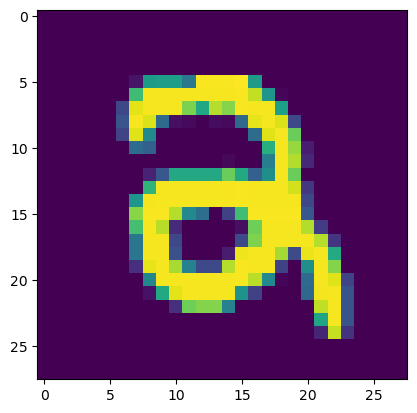

In [119]:
plt.imshow(dataset.data[1134].detach().numpy())
plt.show()

In [130]:
# После того, как модель отработала, навесил еще тангенс с возведением в степень для повышения контрасности. Картинка стала более красивой.

## VAE

In [161]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [162]:
dataset = datasets.MNIST('.', download=True)

In [194]:
# hyperparams
in_chan = 1
hidden_ch = 64
out_ch = 3
device_id = 0
device = 'cpu' if device_id == -1 else 'mps'
n_epochs = 7
batch_size = 128


In [195]:
class Encoder(nn.Module):
  #28x28 -> 14x14 -> 7x7 
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.MaxPool2d(2, 2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7 x 7
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.do3 = nn.Dropout(0.05)
    self.conv_mu = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.conv_sigma = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.pool1(self.conv1(x))))
    x = self.do2(self.activ(self.pool2(self.conv2(x))))
    x = self.do3(self.activ(self.conv3(x)))
    mu = self.conv_mu(x)
    sigma = torch.exp(self.conv_sigma(x))

    return mu, sigma

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()
    self.conv4 = nn.Conv2d(hidden_ch, in_chan, kernel_size=5, stride=1, padding=2)

  def forward(self, x):
    x = self.do1(self.activ(self.upsample1(self.conv1(x))))
    x = self.do2(self.activ(self.upsample2(self.conv2(x))))
    x = self.conv3(x)
    x = self.activ(x)
    x = self.conv4(x)

    return x

def sampling(mu, sigma):
  norm = torch.normal(torch.zeros_like(sigma), torch.ones_like(sigma))
  return mu + sigma * norm

class ConvVarAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = Encoder(in_chan, hidden_ch, out_ch)
    self.decoder = Decoder(in_chan, hidden_ch, out_ch)

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma


In [196]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [197]:
model_conv = ConvVarAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.MSELoss()

def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))

    return torch.distributions.kl_divergence(p, q).mean()

epoch: 0, step: 0, loss: 0.1310054063796997
epoch: 0, step: 200, loss: 0.023817550390958786
epoch: 0, step: 400, loss: 0.017806733027100563


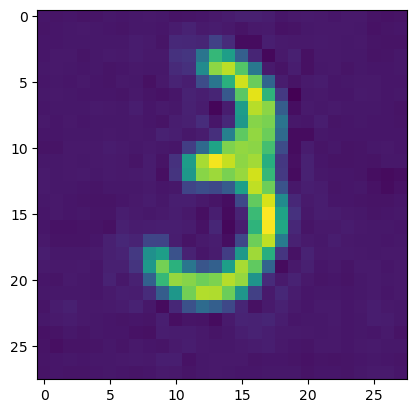

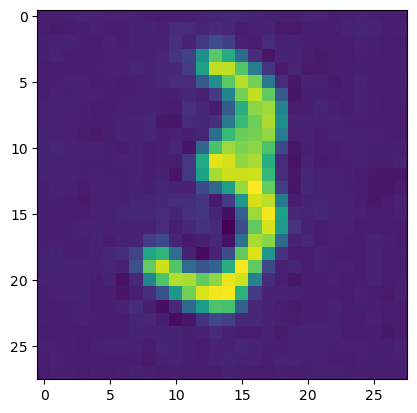

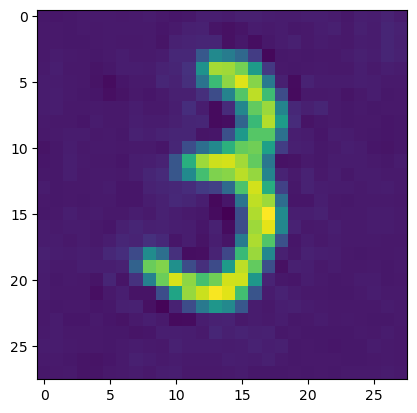

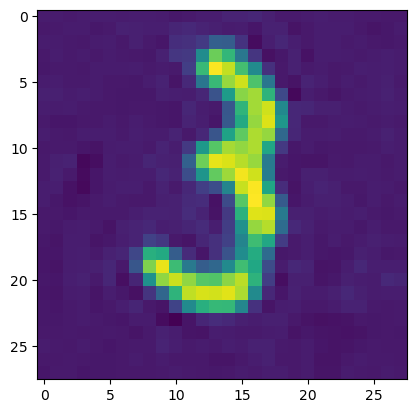

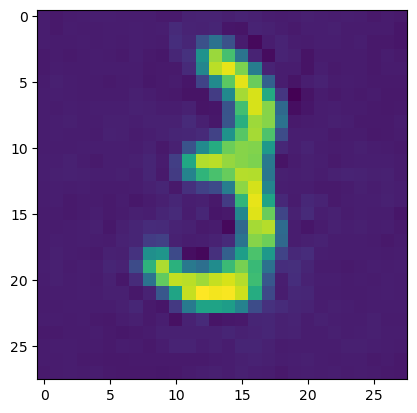

epoch: 1, step: 0, loss: 0.017331277951598167
epoch: 1, step: 200, loss: 0.01592903770506382
epoch: 1, step: 400, loss: 0.015128099359571934


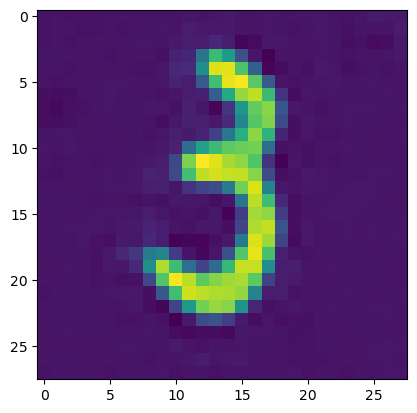

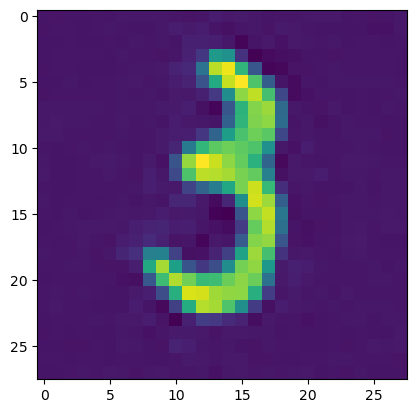

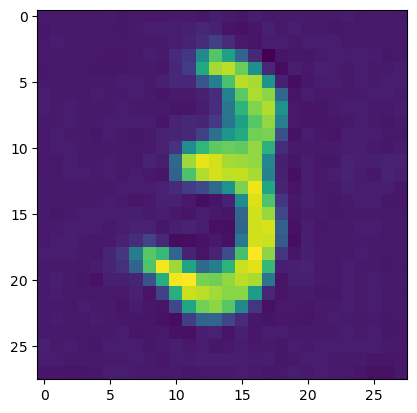

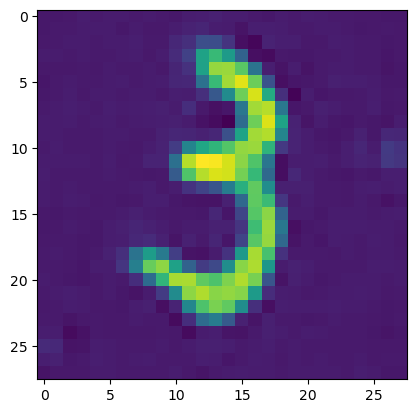

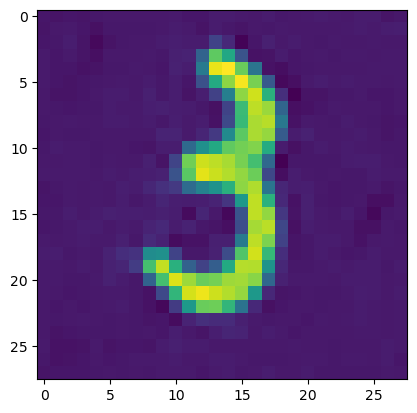

epoch: 2, step: 0, loss: 0.014436204917728901
epoch: 2, step: 200, loss: 0.013079261407256126
epoch: 2, step: 400, loss: 0.01362597569823265


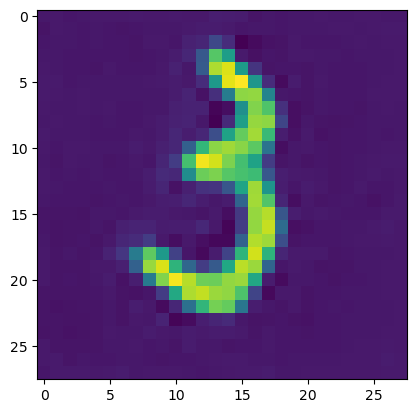

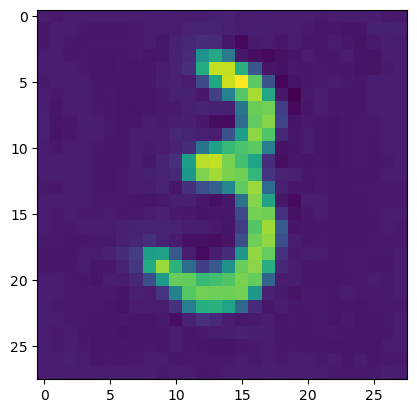

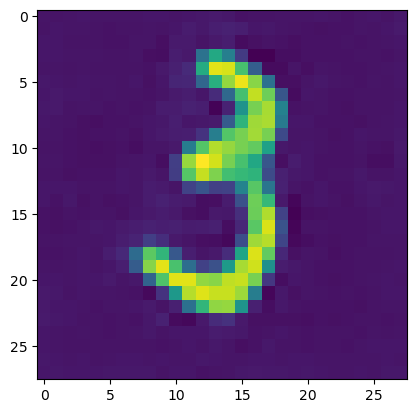

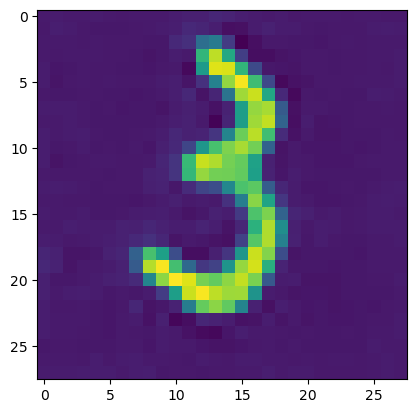

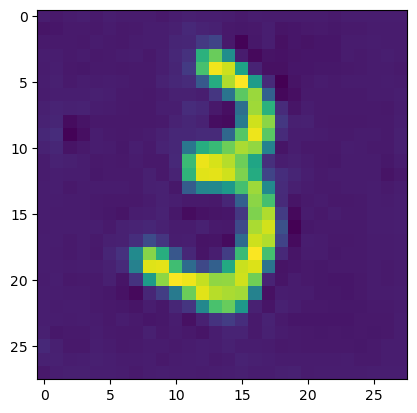

epoch: 3, step: 0, loss: 0.013622576370835304
epoch: 3, step: 200, loss: 0.01336937490850687
epoch: 3, step: 400, loss: 0.012761487625539303


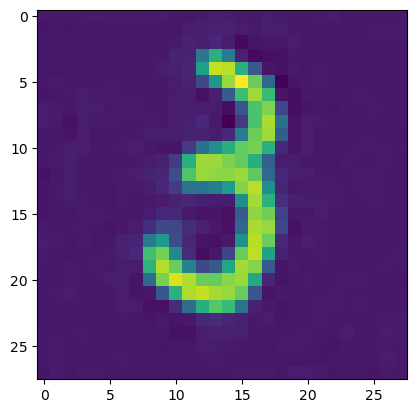

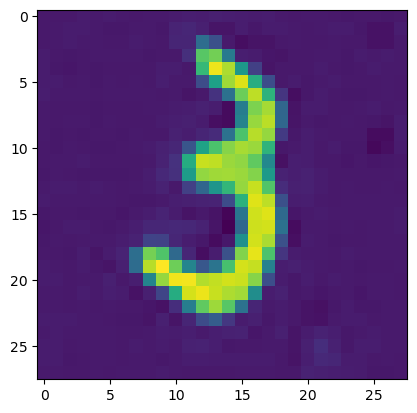

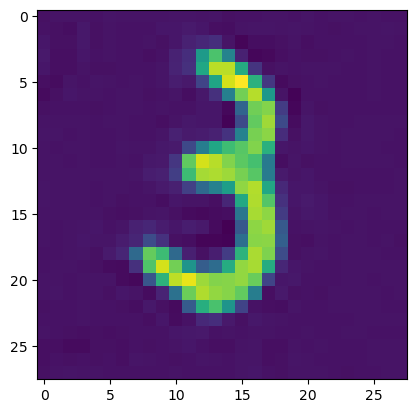

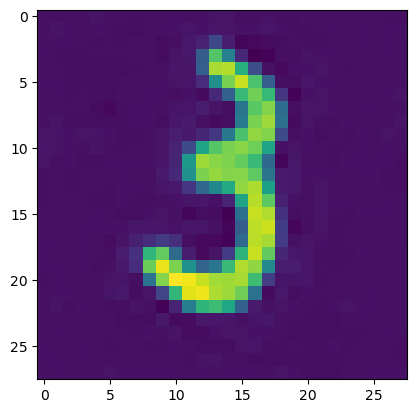

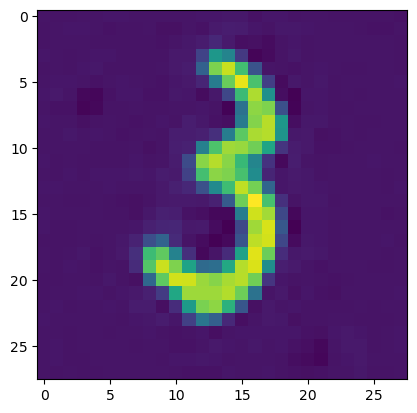

epoch: 4, step: 0, loss: 0.013084366917610168
epoch: 4, step: 200, loss: 0.01249059196561575
epoch: 4, step: 400, loss: 0.013061253353953362


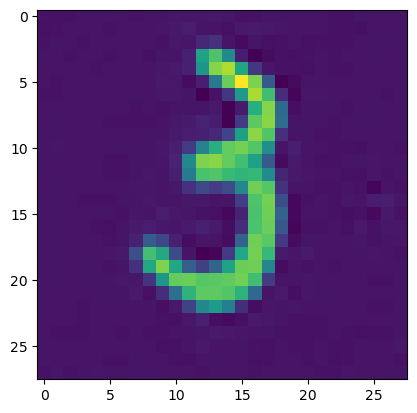

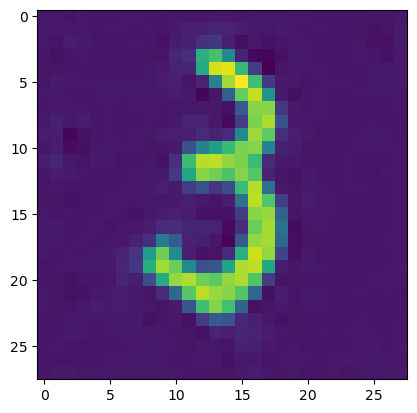

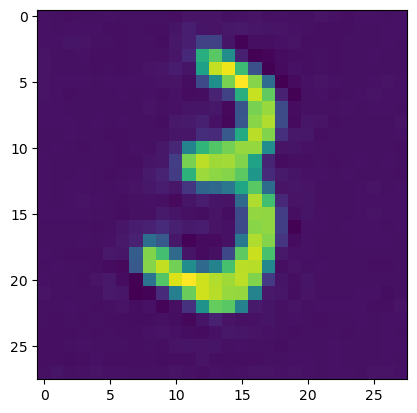

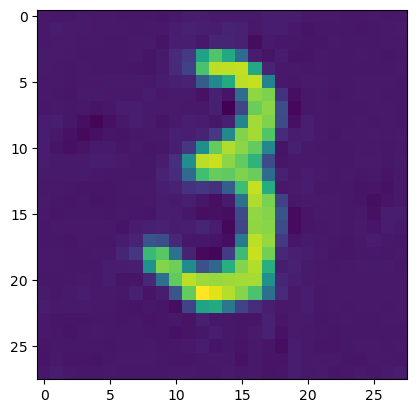

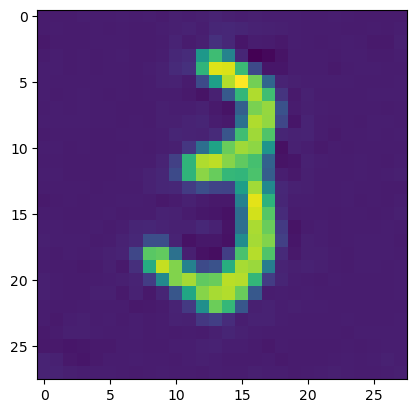

epoch: 5, step: 0, loss: 0.01187305897474289
epoch: 5, step: 200, loss: 0.012163423001766205
epoch: 5, step: 400, loss: 0.011975545436143875


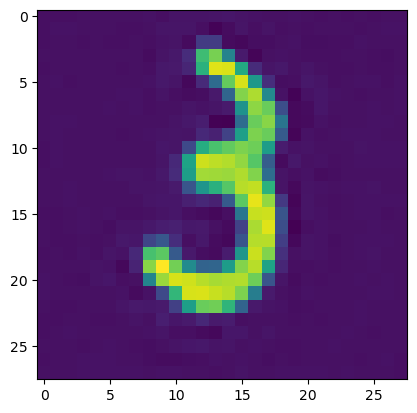

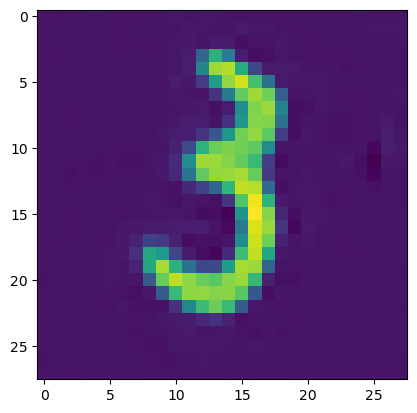

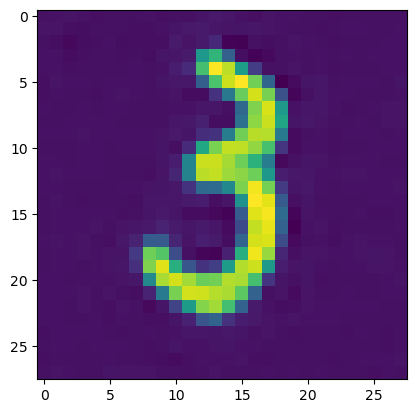

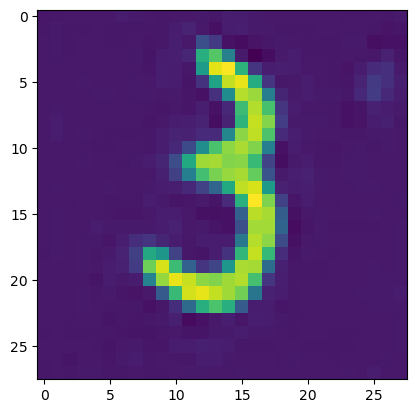

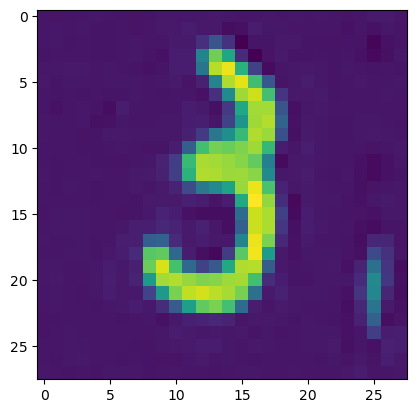

epoch: 6, step: 0, loss: 0.011997615918517113
epoch: 6, step: 200, loss: 0.011866053566336632
epoch: 6, step: 400, loss: 0.011638116091489792


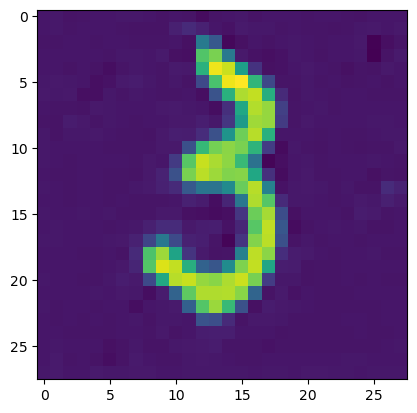

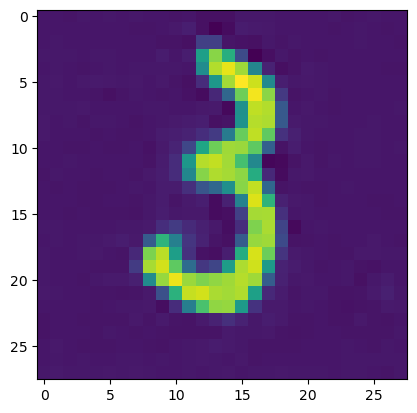

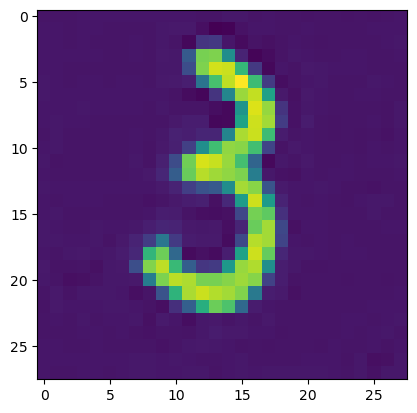

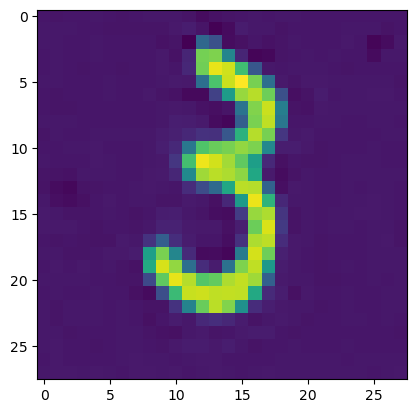

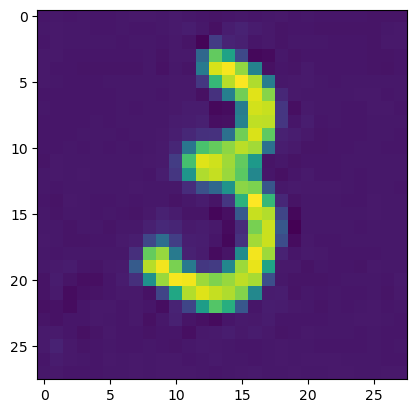

In [198]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    data = batch['data'].to(device)
    # noized = torch.clamp(data + 
    #                      torch.normal(torch.zeros_like(data), 
    #                                   noise_factor * torch.ones_like(data)), 0., 1.)
    predict, mu, sigma = model_conv(data)
    loss = loss_func(predict, data) + 0.01 * kl_loss(mu, sigma)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  mu, sigma = model_conv.encoder(item.to(device))
  # item = torch.normal(torch.zeros((1,1,7,7)), 3 * torch.ones((1,1,7,7)))
  for i in range(5):
    plt.imshow(model_conv.decoder(sampling(mu, sigma))[0].squeeze().cpu().detach().numpy())
    plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')

In [200]:
# Немного слоев добавил, снизил хидден каналы и добавил каналов между энкодером и декодером. 
# Качество картинки выросло.  Если добавить еще каналов межде декодером и энкодером, качество будет лучше.